# Create models.py

You are tasked with defining the network in the `models.py` file so that any models you define can be saved and loaded by name in different notebooks in this project directory. For example, by defining a CNN class called `Net` in `models.py`, you can then create that same architecture in this and other notebooks by simply importing the class and instantiating a model:
```
    from models import Net
    net = Net()
```

In [1]:
# import the usual resources
import matplotlib.pyplot as plt
import numpy as np

# watch for any changes in model.py, if it changes, re-load it automatically
%load_ext autoreload
%autoreload 2

In [2]:
## TODO: Define the Net in models.py

import torch
import torch.nn as nn
import torch.nn.functional as F

## TODO: Once you've define the network, you can instantiate it
# one example conv layer has been provided for you
from models import Net

net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv1_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv2_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv3_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxPool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc3): Linear(in_features=86528, out_features=10, bias=True)
  (fc4): Linear(in_features=10, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


## Reloading last saved set of weights

In [3]:
model_dir = 'saved_models/'
model_name = 'keypoints_model_1.pt'

net.load_state_dict(torch.load(model_dir+model_name))
net.eval()

Net(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv1_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv2_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv3_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxPool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc3): Linear(in_features=86528, out_features=10, bias=True)
  (fc4): Linear(in_features=10, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

## Transform the dataset 

To prepare for training, create a transformed dataset of images and keypoints.



In [4]:
# !conda install opencv -y

# Let us define the data loaders

In [5]:
import glob
import os

# extract class name from the class folder
def getFolderClass(str):
    parts = str.split('/')
    return parts[-1]

# extract class name from a file name
def getFileClass(str):
    parts = str.split('/')
    return parts[-2]

def extractClassNames(folder):
    class_folders = glob.glob(os.path.join(folder,'*'))
    class_names = [ getFolderClass(f) for f in class_folders ]
    
    newdict = {}
    translator = {}
    for i,c in enumerate(class_names):
        newdict[c] = i
        translator[i] = c
    
    return newdict,translator
     

In [6]:
print(extractClassNames('data/training'))

({'freshapples': 0, 'rottenapples': 1}, {0: 'freshapples', 1: 'rottenapples'})


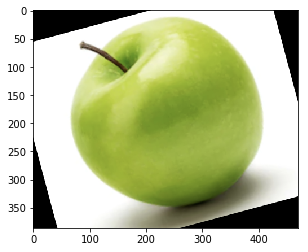

In [7]:
import matplotlib.image as mpimg
files = glob.glob(os.path.join('data/training','*/*'))

image = mpimg.imread(files[1])

plt.imshow(image)

In [8]:
import glob
import os
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np

import pandas as pd
import cv2


class FruitsDataset(Dataset):
    """Fruits"""

    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.root_dir = root_dir
        
        # all files that need to be loaded
        self.files = glob.glob(os.path.join(root_dir,'*/*'))
        
        # classes where those files are
        self.classes,_ = extractClassNames(root_dir)
        
        self.transform = transform

    def __len__(self):
        
        # TODO define lenght (number of files in set)
        return len(self.files)

    def __getitem__(self, idx):
        image_name = self.files[idx]
        
        image = mpimg.imread(image_name)
        
        # if image has an alpha color channel, get rid of it
        if(image.shape[2] == 4):
             image = image[:,:,0:3]
        
        img_class = np.array([self.classes[getFileClass(image_name)]]).astype('float') # read dict with class 
        sample = {'image': image, 'class': img_class}

        if self.transform:
            sample = self.transform(sample)

        return sample
    

    
# tranforms

class Normalize(object):
    """Convert a color image to grayscale and normalize the color range to [0,1]."""        

    def __call__(self, sample):
        image, img_class = sample['image'], sample['class']
        
        image_copy = np.copy(image)
        img_class_copy = np.copy(img_class)

        # convert image to grayscale
        # image_copy = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        
        # scale color range from [0, 255] to [0, 1]
        image_copy=  image_copy/255.0
        
        return {'image': image_copy, 'class': img_class}


class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, img_class = sample['image'], sample['class']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = cv2.resize(image, (new_w, new_h))
        
        return {'image': img, 'class': img_class}


class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, img_class = sample['image'], sample['class']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        img = image[top: top + new_h,
                      left: left + new_w]


        return {'image': img, 'class': img_class}


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, img_class = sample['image'], sample['class']
         
        # if image has no grayscale color channel, add one
        if(len(image.shape) == 2):
            # add that third color dim
            image = image.reshape(image.shape[0], image.shape[1], 1)
            
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        
        return {'image': torch.from_numpy(image),
                'class': torch.from_numpy(img_class)}

In [9]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils


## TODO: define the data_transform using transforms.Compose([all tx's, . , .])
# order matters! i.e. rescaling should come before a smaller crop
data_transform = transforms.Compose([Rescale(250),
                                     RandomCrop(224),
                                     Normalize(),
                                     ToTensor()])



# testing that you've defined a transform
# assert(data_transform is not None), 'Define a data_transform'

In [10]:
# create the transformed dataset
transformed_dataset = FruitsDataset(root_dir='data/training/',
                                    transform=data_transform)


print('Number of images: ', len(transformed_dataset))

print(len(transformed_dataset[0]['class']))

# iterate through the transformed dataset and print some stats about the first few samples
for i in range(4):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['class'].size())

Number of images:  4035
1
0 torch.Size([3, 224, 224]) torch.Size([1])
1 torch.Size([3, 224, 224]) torch.Size([1])
2 torch.Size([3, 224, 224]) torch.Size([1])
3 torch.Size([3, 224, 224]) torch.Size([1])


## Batching and loading data

Next, having defined the transformed dataset, we can use PyTorch's DataLoader class to load the training data in batches of whatever size as well as to shuffle the data for training the model. You can read more about the parameters of the DataLoader, in [this documentation](http://pytorch.org/docs/master/data.html).

#### Batch size
Decide on a good batch size for training your model. Try both small and large batch sizes and note how the loss decreases as the model trains.

**Note for Windows users**: Please change the `num_workers` to 0 or you may face some issues with your DataLoader failing.

In [11]:
# load training data in batches
batch_size = 10

train_loader = DataLoader(transformed_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=0)


## Before training

Take a look at how this model performs before it trains. You should see that the keypoints it predicts start off in one spot and don't match the keypoints on a face at all! It's interesting to visualize this behavior so that you can compare it to the model after training and see how the model has improved.

#### Load in the test dataset

The test dataset is one that this model has *not* seen before, meaning it has not trained with these images. We'll load in this test data and before and after training, see how your model performs on this set!

To visualize this test data, we have to go through some un-transformation steps to turn our images into python images from tensors and to turn our keypoints back into a recognizable range. 

In [12]:
# load in the test data, using the dataset class
# AND apply the data_transform you defined above

# create the test dataset
test_dataset = FruitsDataset(root_dir='data/test/',
                            transform=data_transform)



In [13]:
# load test data in batches
batch_size = 10

test_loader = DataLoader(test_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=0)

## Apply the model on a test sample

To test the model on a test sample of data, you have to follow these steps:
1. Extract the image and ground truth keypoints from a sample
2. Make sure the image is a FloatTensor, which the model expects.
3. Forward pass the image through the net to get the predicted, output keypoints.

This function test how the network performs on the first batch of test data. It returns the images, the transformed images, the predicted keypoints (produced by the model), and the ground truth keypoints.

In [14]:
# test the model on a batch of test images

def net_sample_output(sample_number=0,start_from=0):
    
    all_images = all_outputs = all_classes = torch.tensor([])
 
    # read and discard images until we reach the starting point
    for i in range(start_from):
        _ = test_loader
        
    # iterate through the test dataset
    for i, sample in enumerate(test_loader):
        
        # get sample data: images and ground truth keypoints
        images = sample['image']
        classes = sample['class']

        # convert images to FloatTensors
        images = images.type(torch.FloatTensor)
        classes = classes.type(torch.FloatTensor)
        

        # forward pass to get net output
        output_classes = net(images)
        
        all_images = torch.cat((all_images,images))
        all_outputs = torch.cat((all_outputs,output_classes))
        all_classes = torch.cat((all_classes,classes))
        
        
        # break after first image is tested
        if i == sample_number:
            return all_images, all_outputs, all_classes
            

#### Debugging tips

If you get a size or dimension error here, make sure that your network outputs the expected number of keypoints! Or if you get a Tensor type error, look into changing the above code that casts the data into float types: `images = images.type(torch.FloatTensor)`.

In [15]:
# call the above function
# returns: test images, test predicted keypoints, test ground truth keypoints
test_images, test_outputs, gt_pts = net_sample_output(start_from=5)

# print out the dimensions of the data to see if they make sense
print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([10, 3, 224, 224])
torch.Size([10, 1])
torch.Size([10, 1])


#### Un-transformation

Next, you'll see a helper function. `visualize_output` that takes in a batch of images, predicted keypoints, and ground truth keypoints and displays a set of those images and their true/predicted keypoints.

This function's main role is to take batches of image and keypoint data (the input and output of your CNN), and transform them into numpy images and un-normalized keypoints (x, y) for normal display. The un-transformation process turns keypoints and images into numpy arrays from Tensors *and* it undoes the keypoint normalization done in the Normalize() transform; it's assumed that you applied these transformations when you loaded your test data.

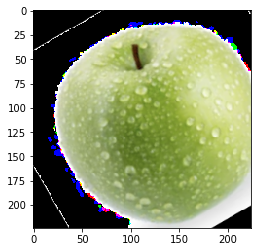

In [16]:
image = test_images[0].data   # get the image from it's wrapper
image = image.numpy() * 256   # convert to numpy array from a Tensor
image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image
plt.imshow(image)

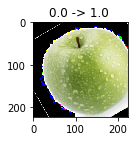

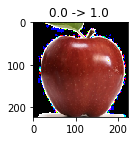

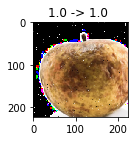

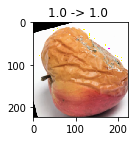

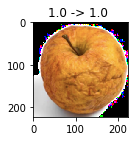

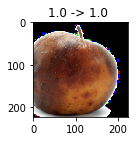

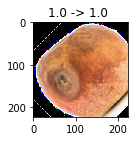

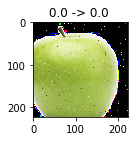

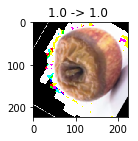

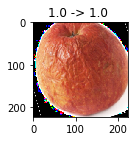

Accuracy: 80.0%


In [17]:
# visualize the output
# by default this shows a batch of 10 images
def visualize_output(test_images, test_outputs, gt_pts, batch_size=10):

    no_samples = 0 
    
    running_acc = 0.0
    
    to = test_outputs.round()
    
    for i,_ in enumerate(test_images):
        plt.figure(figsize=(len(test_images)* 2, 10))
        ax = plt.subplot(1, len(test_images), i+1)

        # un-transform the image data
        image = test_images[i].data   # get the image from it's wrapper
        image = image.numpy() * 256  # convert to numpy array from a Tensor
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image
        plt.imshow(np.squeeze(image))
        plt.title('{} -> {} '.format(gt_pts[i,0],to[i,0]))
        plt.axis('on')
        

        if gt_pts[i,0].item() == to[i,0].item():
            running_acc += 1

        no_samples = i + 1
            
    plt.show()
    
    print('Accuracy: {}%'.format(running_acc * 100 / no_samples))
# call it
visualize_output(test_images,test_outputs, gt_pts )

## Training

#### Loss function
Training a network to predict keypoints is different than training a network to predict a class; instead of outputting a distribution of classes and using cross entropy loss, you may want to choose a loss function that is suited for regression, which directly compares a predicted value and target value. Read about the various kinds of loss functions (like MSE or L1/SmoothL1 loss) in [this documentation](http://pytorch.org/docs/master/_modules/torch/nn/modules/loss.html).

### TODO: Define the loss and optimization

Next, you'll define how the model will train by deciding on the loss function and optimizer.

---

In [18]:
## TODO: Define the loss and optimization
import torch.optim as optim

learning_rate = 0.0003
criterion = nn.BCELoss()

optimizer = optim.SGD(net.parameters(), lr =learning_rate  , momentum= 0.9)


## Training and Initial Observation

Now, you'll train on your batched training data from `train_loader` for a number of epochs. 

To quickly observe how your model is training and decide on whether or not you should modify it's structure or hyperparameters, you're encouraged to start off with just one or two epochs at first. As you train, note how your the model's loss behaves over time: does it decrease quickly at first and then slow down? Does it take a while to decrease in the first place? What happens if you change the batch size of your training data or modify your loss function? etc. 

Use these initial observations to make changes to your model and decide on the best architecture before you train for many epochs and create a final model.

In [19]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def asList(arr):
    
    return [a[0] for a in arr]

In [20]:
def train_net(n_epochs):

    # prepare the net for training
    net.train()
    
    _acc = 0.0

    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        running_loss = 0.0
        
        ##################################################################
        # Calculating error  ... START
        ##################################################################
        running_acc = 0.0
        
        err_debug = False  # set it to true to see each step of error calc

        ##################################################################
        # Calculating error  ... END
        ##################################################################


        # train on batches of data, assumes you already have train_loader
        for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding labels
            images = data['image']
            img_class = data['class']

            # convert variables to floats for regression loss
            img_class = img_class.type(torch.FloatTensor)
            images = images.type(torch.FloatTensor)
            
            ##################################################################
            # CUDA ... START
            ##################################################################
            img_class = img_class.to(device)
            images   = images.to(device)
            ##################################################################
            # CUDA ... end
            ##################################################################
            
            # forward pass to get outputs
            output_class = net(images)

            # calculate the loss between predicted and target keypoints
            loss = criterion(output_class, img_class)
            
            running_acc += torch.eq(img_class, output_class.round()).sum()

            
            ##################################################################
            # Calculating error  ... START
            ##################################################################     
            if err_debug:
                # Values
                print( '\n\n\===> New batch: \nPoint: {} '.format(img_class.tolist())  )            
                print( 'Output: {} '.format(output_class.round()))             
                print( 'Equal: {}'.format(torch.eq(img_class, output_class.round()).tolist()))
                print( 'No of correct: {}'.format(torch.eq(img_class, output_class.round()).sum()))

    
            ##################################################################
            # Calculating error  ... END
            ##################################################################
            
            # zero the parameter (weight) gradients
            optimizer.zero_grad()
            
            # backward pass to calculate the weight gradients
            loss.backward()

            # update the weights
            optimizer.step()

            # print loss statistics
            running_loss += loss.item()
            
            
            if batch_i % 10 == 9:    # print every 10 batches
                print('Epoch: {}, Batch: {}, Avg. Loss: {} Avg. Accuracy: {}%'
                      .format(epoch + 1, batch_i+1, 
                              running_loss / (batch_size * 10) , 
                              running_acc  * 100 / (batch_size  * 10) ))
                
                ##################################################################
                # Calculating error  ... START
                ##################################################################
                
                _acc  = running_acc
                _loss = running_loss

                running_loss = 0.0
                running_acc = 0.0
                
                ##################################################################
                # Calculating error  ... END
                ##################################################################                

    print('Finished Training')

    history = {'acc' : _acc, 'loss': _loss }
    return history




In [ ]:
# train your network
n_epochs = 3 # start small, and increase when you've decided on your model structure and hyperparams

history = train_net(n_epochs)

## Test data

See how your model performs on previously unseen, test data. We've already loaded and transformed this data, similar to the training data. Next, run your trained model on these images to see what kind of keypoints are produced. You should be able to see if your model is fitting each new face it sees, if the points are distributed randomly, or if the points have actually overfitted the training data and do not generalize.

In [ ]:
# get a sample of test data again
test_images, test_outputs, gt_pts = net_sample_output(3,1)

print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

In [ ]:
## TODO: visualize your test output
# you can use the same function as before, by un-commenting the line below:

visualize_output(test_images, test_outputs, gt_pts)


Once you've found a good model (or two), save your model so you can load it and use it later!

In [ ]:
## TODO: change the name to something uniqe for each new model
model_dir = 'saved_models/'
model_name = 'best.pt'

# after training, save your model parameters in the dir 'saved_models'
torch.save(net.state_dict(), model_dir+model_name)